#Evaluation -  id11010024

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

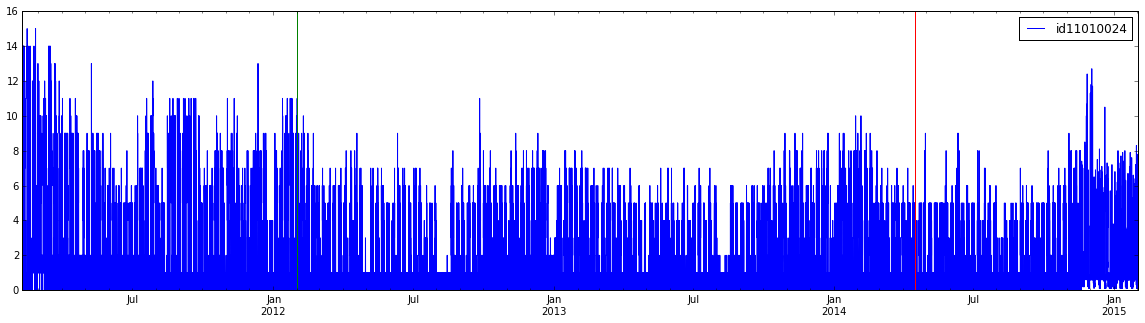

In [4]:
f = original_data[["id11010024"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [5]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
from neural_network import PyBrainNN

## Creating Feature Sets

In [6]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [7]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Prediction Results

In [8]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [9]:
baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             {'name': "AR", 'ftrs': ar_ftrs},
             {'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             {'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             {'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             {'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             {'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             {'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [10]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id11010024']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        for horizon in range (1,25):
        #for horizon in range (1,4):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

Working with sensor: id11010024

	-->Prediction horizont: 1h. Shifting runtime: 16.88s

		-->Dataset: Baselines. X_train: (77377L, 16L), y_train: (77377L,)

D:\Users\bkazic\Envs\py27_64bit\lib\site-packages\pandas\core\frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
regression_metrics.py:27: RuntimeWarning: Found 10015 zero elements in y_pred. Removing 10015 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



			-->Computing Last value
				-->R2: 0.553
				-->MAE: 0.557
				-->MAPE: 46.047
				-->MASE: 0.920
			-->Computing Previous day
				-->R2: 0.123
				-->MAE: 0.867
				-->MAPE: 92.361
				-->MASE: 1.433
			-->Computing Previous week
				-->R2: 0.432
				-->MAE: 0.696
				-->MAPE: 57.775
				-->MASE: 1.151

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 1.51s
				-->R2: 0.713
				-->MAE: 0.577
				-->MAPE: 51.787
				-->MASE: 0.954
			-->Training model: K Nearest Neighbors, runtime: 0.75s
				-->R2: 0.683
				-->MAE: 0.588
				-->MAPE: 53.695
				-->MASE: 0.971
			-->Training model: Random Forest, runtime: 25.36s
				-->R2: 0.738
				-->MAE: 0.551
				-->MAPE: 46.359
				-->MASE: 0.910

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.53s
				-->R2: 0.716
				-->MAE: 0.593
				-->MAPE: 53.842
				-->MASE: 0.979
			-->Training model: K Nearest Neighbors, r

regression_metrics.py:27: RuntimeWarning: Found 10012 zero elements in y_pred. Removing 10012 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10009 zero elements in y_pred. Removing 10009 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



				-->MAE: 0.919
				-->MAPE: 83.582
				-->MASE: 0.920
			-->Computing Previous day
				-->R2: 0.123
				-->MAE: 0.868
				-->MAPE: 92.421
				-->MASE: 0.869
			-->Computing Previous week
				-->R2: 0.432
				-->MAE: 0.697
				-->MAPE: 57.807
				-->MASE: 0.698

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.03s
				-->R2: 0.622
				-->MAE: 0.683
				-->MAPE: 62.444
				-->MASE: 0.684
			-->Training model: K Nearest Neighbors, runtime: 0.62s
				-->R2: 0.591
				-->MAE: 0.673
				-->MAPE: 61.609
				-->MASE: 0.674
			-->Training model: Random Forest, runtime: 23.20s
				-->R2: 0.656
				-->MAE: 0.637
				-->MAPE: 54.755
				-->MASE: 0.638

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.42s
				-->R2: 0.626
				-->MAE: 0.701
				-->MAPE: 65.196
				-->MASE: 0.702
			-->Training model: K Nearest Neighbors, runtime: 1.04s
				-->R2: -0.147
				-->MAE: 

regression_metrics.py:27: RuntimeWarning: Found 10006 zero elements in y_pred. Removing 10006 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10003 zero elements in y_pred. Removing 10003 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



				-->MAE: 1.213
				-->MAPE: 105.300
				-->MASE: 0.962
			-->Computing Previous day
				-->R2: 0.123
				-->MAE: 0.869
				-->MAPE: 92.530
				-->MASE: 0.689
			-->Computing Previous week
				-->R2: 0.432
				-->MAE: 0.698
				-->MAPE: 57.860
				-->MASE: 0.553

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.03s
				-->R2: 0.587
				-->MAE: 0.708
				-->MAPE: 60.234
				-->MASE: 0.561
			-->Training model: K Nearest Neighbors, runtime: 0.56s
				-->R2: 0.544
				-->MAE: 0.706
				-->MAPE: 62.194
				-->MASE: 0.560
			-->Training model: Random Forest, runtime: 21.37s
				-->R2: 0.614
				-->MAE: 0.668
				-->MAPE: 53.046
				-->MASE: 0.530

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.37s
				-->R2: 0.590
				-->MAE: 0.732
				-->MAPE: 63.937
				-->MASE: 0.580
			-->Training model: K Nearest Neighbors, runtime: 0.80s
				-->R2: -0.117
				-->MAE:

regression_metrics.py:27: RuntimeWarning: Found 10001 zero elements in y_pred. Removing 10001 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10000 zero elements in y_pred. Removing 10000 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



				-->MAE: 1.716
				-->MAPE: 148.223
				-->MASE: 0.987
			-->Computing Previous day
				-->R2: 0.127
				-->MAE: 0.865
				-->MAPE: 88.896
				-->MASE: 0.497
			-->Computing Previous week
				-->R2: 0.426
				-->MAE: 0.701
				-->MAPE: 58.450
				-->MASE: 0.403

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.03s
				-->R2: 0.563
				-->MAE: 0.712
				-->MAPE: 57.699
				-->MASE: 0.410
			-->Training model: K Nearest Neighbors, runtime: 0.53s
				-->R2: 0.517
				-->MAE: 0.726
				-->MAPE: 58.969
				-->MASE: 0.418
			-->Training model: Random Forest, runtime: 24.10s
				-->R2: 0.543
				-->MAE: 0.716
				-->MAPE: 55.164
				-->MASE: 0.412

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.43s
				-->R2: 0.566
				-->MAE: 0.736
				-->MAPE: 62.011
				-->MASE: 0.423
			-->Training model: K Nearest Neighbors, runtime: 0.73s
				-->R2: -0.128
				-->MAE:

regression_metrics.py:27: RuntimeWarning: Found 9998 zero elements in y_pred. Removing 9998 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9995 zero elements in y_pred. Removing 9995 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



				-->MAE: 1.553
				-->MAPE: 135.220
				-->MASE: 0.975
			-->Computing Previous day
				-->R2: 0.122
				-->MAE: 0.865
				-->MAPE: 89.038
				-->MASE: 0.543
			-->Computing Previous week
				-->R2: 0.423
				-->MAE: 0.701
				-->MAPE: 58.593
				-->MASE: 0.440

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.03s
				-->R2: 0.561
				-->MAE: 0.713
				-->MAPE: 58.134
				-->MASE: 0.447
			-->Training model: K Nearest Neighbors, runtime: 0.55s
				-->R2: 0.520
				-->MAE: 0.720
				-->MAPE: 60.688
				-->MASE: 0.452
			-->Training model: Random Forest, runtime: 24.10s
				-->R2: 0.570
				-->MAE: 0.697
				-->MAPE: 54.478
				-->MASE: 0.437

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.43s
				-->R2: 0.565
				-->MAE: 0.735
				-->MAPE: 62.335
				-->MASE: 0.461
			-->Training model: K Nearest Neighbors, runtime: 0.83s
				-->R2: -0.100
				-->MAE:

regression_metrics.py:27: RuntimeWarning: Found 9992 zero elements in y_pred. Removing 9992 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9989 zero elements in y_pred. Removing 9989 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



				-->MAE: 1.352
				-->MAPE: 114.726
				-->MASE: 0.972
			-->Computing Previous day
				-->R2: 0.125
				-->MAE: 0.862
				-->MAPE: 89.338
				-->MASE: 0.620
			-->Computing Previous week
				-->R2: 0.421
				-->MAE: 0.701
				-->MAPE: 58.683
				-->MASE: 0.504

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.04s
				-->R2: 0.562
				-->MAE: 0.713
				-->MAPE: 58.665
				-->MASE: 0.512
			-->Training model: K Nearest Neighbors, runtime: 0.64s
				-->R2: 0.530
				-->MAE: 0.719
				-->MAPE: 60.439
				-->MASE: 0.517
			-->Training model: Random Forest, runtime: 22.74s
				-->R2: 0.580
				-->MAE: 0.687
				-->MAPE: 54.808
				-->MASE: 0.494

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.45s
				-->R2: 0.565
				-->MAE: 0.734
				-->MAPE: 62.776
				-->MASE: 0.527
			-->Training model: K Nearest Neighbors, runtime: 0.73s
				-->R2: -0.072
				-->MAE:

regression_metrics.py:27: RuntimeWarning: Found 9987 zero elements in y_pred. Removing 9987 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9984 zero elements in y_pred. Removing 9984 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



				-->MAE: 1.172
				-->MAPE: 109.187
				-->MASE: 0.969
			-->Computing Previous day
				-->R2: 0.130
				-->MAE: 0.862
				-->MAPE: 86.927
				-->MASE: 0.712
			-->Computing Previous week
				-->R2: 0.420
				-->MAE: 0.704
				-->MAPE: 58.954
				-->MASE: 0.582

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.05s
				-->R2: 0.568
				-->MAE: 0.714
				-->MAPE: 59.280
				-->MASE: 0.590
			-->Training model: K Nearest Neighbors, runtime: 1.04s
				-->R2: 0.518
				-->MAE: 0.728
				-->MAPE: 61.671
				-->MASE: 0.602
			-->Training model: Random Forest, runtime: 33.74s
				-->R2: 0.569
				-->MAE: 0.692
				-->MAPE: 55.783
				-->MASE: 0.572

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.42s
				-->R2: 0.571
				-->MAE: 0.734
				-->MAPE: 62.892
				-->MASE: 0.607
			-->Training model: K Nearest Neighbors, runtime: 0.91s
				-->R2: -0.009
				-->MAE:

regression_metrics.py:27: RuntimeWarning: Found 9981 zero elements in y_pred. Removing 9981 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9978 zero elements in y_pred. Removing 9978 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



				-->MAE: 0.975
				-->MAPE: 96.954
				-->MASE: 0.976
			-->Computing Previous day
				-->R2: 0.134
				-->MAE: 0.860
				-->MAPE: 86.105
				-->MASE: 0.861
			-->Computing Previous week
				-->R2: 0.418
				-->MAE: 0.705
				-->MAPE: 59.032
				-->MASE: 0.706

		-->Dataset: AR. X_train: (77377L, 16L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.04s
				-->R2: 0.567
				-->MAE: 0.720
				-->MAPE: 61.104
				-->MASE: 0.721
			-->Training model: K Nearest Neighbors, runtime: 0.70s
				-->R2: 0.505
				-->MAE: 0.735
				-->MAPE: 65.186
				-->MASE: 0.735
			-->Training model: Random Forest, runtime: 23.99s
				-->R2: 0.589
				-->MAE: 0.673
				-->MAPE: 56.075
				-->MASE: 0.673

		-->Dataset: AR_WC_WF. X_train: (77377L, 67L), y_train: (77377L,)
			-->Training model: Ridge Regression, runtime: 0.39s
				-->R2: 0.571
				-->MAE: 0.737
				-->MAPE: 63.975
				-->MASE: 0.737
			-->Training model: K Nearest Neighbors, runtime: 0.87s
				-->R2: -0.034
				-->MAE: 

regression_metrics.py:27: RuntimeWarning: Found 9975 zero elements in y_pred. Removing 9975 zero elements
  warnings.warn(warning_msg, RuntimeWarning)


In [11]:
output_file_name = "validationResults_id11010024.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

## Entire Validation Dataset

In [ ]:
#validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

In [12]:
validation_df

sensor                                    id14061709                        \
error metric                                      R2        MAE       MAPE   
horizon dataset       model                                                  
1       Last value    Baselines             0.701514   9.462369  17.108761   
        Previous day  Baselines             0.603052  10.588125  19.384293   
        Previous week Baselines             0.687950   9.336052  16.849250   
        AR            Ridge Regression      0.828730   7.223550  13.260426   
                      K Nearest Neighbors   0.720101   9.362018  17.263276   
                      Random Forest         0.832488   7.091272  12.869314   
        AR_WC_WF      Ridge Regression      0.828857   7.241434  13.315055   
                      K Nearest Neighbors   0.346545  14.358331  29.292576   
                      Random Forest         0.832700   7.135340  13.132118   
        AR_DT         Ridge Regression      0.839049   7.014501  12.850424   
                      K Nearest Neighbors   0.693810   9.846123  18.628006   
                      Random Forest         0.840835   6.927061  12.596201   
        AR_WC_DT      Ridge Regression      0.838647   7.024426  12.795825   
                      K Nearest Neighbors   0.325412  14.632189  30.013603   
                      Random Forest         0.836506   7.069665  13.010132   
        AR_WF_DT      Ridge Regression      0.839015   7.014561  12.817572   
                      K Nearest Neighbors   0.656694  10.436721  19.668894   
                      Random Forest         0.841776   6.910350  12.573027   
        ALL           Ridge Regression      0.838523   7.028306  12.807204   
                      K Nearest Neighbors   0.332360  14.521205  29.712523   
                      Random Forest         0.835787   7.079876  13.018790   
        TOP_20        Ridge Regression      0.838967   7.022842  12.856511   
                      K Nearest Neighbors   0.791270   8.017038  14.788382   
                      Random Forest         0.840859   6.956002  12.798576   
        TOP_10        Ridge Regression      0.838495   7.021399  12.817194   
                      K Nearest Neighbors   0.794263   7.925659  14.391743   
                      Random Forest         0.838949   6.948460  12.578447   
2       Last value    Baselines             0.427858  13.423055  25.248228   
        Previous day  Baselines             0.603101  10.586499  19.378579   
        Previous week Baselines             0.687844   9.336703  16.847941   
...                                              ...        ...        ...   
23      TOP_10        Ridge Regression      0.774915   8.236376  15.713994   
                      K Nearest Neighbors   0.704398   9.371262  17.355548   
                      Random Forest         0.771306   8.165389  15.210724   
24      Last value    Baselines             0.598930  10.596806  19.263715   
        Previous day  Baselines             0.598930  10.596806  19.263715   
        Previous week Baselines             0.680384   9.438809  16.981493   
        AR            Ridge Regression      0.766952   8.320825  15.868222   
                      K Nearest Neighbors   0.630671  10.603912  20.025915   
                      Random Forest         0.762541   8.303332  15.501076   
        AR_WC_WF      Ridge Regression      0.766400   8.380748  15.995944   
                      K Nearest Neighbors   0.262264  15.280528  30.996251   
                      Random Forest         0.758736   8.466941  16.220407   
        AR_DT         Ridge Regression      0.776788   8.218924  15.672862   
                      K Nearest Neighbors   0.603390  11.085211  21.282248   
                      Random Forest         0.784544   7.997916  14.880271   
        AR_WC_DT      Ridge Regression      0.776243   8.254456  15.578951   
                      K Nearest Neighbors   0.255450  15.344996  31.412700   
                      

## Evaluation Scores Over All Horizons

In [13]:
validation_df.groupby(level=['dataset', 'model']).mean()

sensor                            id14061709                                
error metric                              R2        MAE       MAPE      MASE
dataset       model                                                         
Last value    Baselines            -0.863642  24.807075  49.713539  0.951775
Previous day  Baselines             0.601026  10.595415  19.372795  0.470952
Previous week Baselines             0.685389   9.365809  16.878461  0.416474
AR            Ridge Regression      0.772101   8.248716  15.659039  0.363020
              K Nearest Neighbors   0.625963  10.706661  20.130294  0.470539
              Random Forest         0.771056   8.170729  15.195938  0.359797
AR_WC_WF      Ridge Regression      0.769760   8.341075  15.892076  0.366597
              K Nearest Neighbors   0.213581  15.819068  32.602714  0.695477
              Random Forest         0.771998   8.233860  15.672544  0.363011
AR_DT         Ridge Regression      0.783398   8.129425  15.464692  0.357366
              K Nearest Neighbors   0.602774  11.093291  21.261620  0.488342
              Random Forest         0.790103   7.897353  14.651935  0.347945
AR_WC_DT      Ridge Regression      0.781609   8.181213  15.419733  0.359461
              K Nearest Neighbors   0.178897  16.222048  33.730424  0.712277
              Random Forest         0.784314   8.069392  15.288127  0.355761
AR_WF_DT      Ridge Regression      0.783550   8.143468  15.407923  0.357997
              K Nearest Neighbors   0.566943  11.607709  22.238097  0.512328
              Random Forest         0.791030   7.873798  14.656489  0.346958
ALL           Ridge Regression      0.781384   8.190953  15.413540  0.359859
              K Nearest Neighbors   0.203077  15.922797  32.906955  0.700385
              Random Forest         0.784303   8.063893  15.292329  0.355527
TOP_20        Ridge Regression      0.781908   8.158835  15.521424  0.358591
              K Nearest Neighbors   0.708397   9.380767  17.506332  0.412864
              Random Forest         0.785287   7.945667  14.971268  0.350019
TOP_10        Ridge Regression      0.782186   8.138126  15.452309  0.357807
              K Nearest Neighbors   0.716834   9.196127  16.936237  0.404830
              Random Forest         0.780333   8.031649  14.865365  0.353719

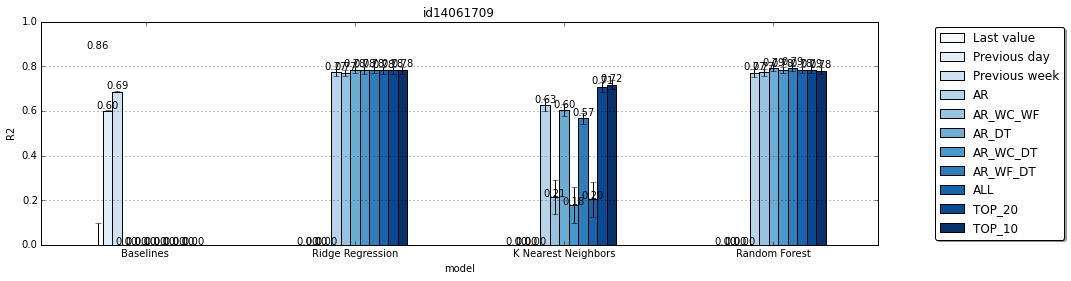

In [14]:
for sensor_id in validation_df.columns.levels[0]:
        
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
            
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel('R2')
    plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [388]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

'\nfor sensor_id in validation_df.columns.levels[0]:\n    ax = validation_df.loc[20][sensor_id][\'R2\'].unstack(0).plot(\n        kind=\'bar\', figsize=(15,4), rot=0, title=sensor_id, colormap=\'Blues\', ylim=(0,1))\n    \n    for p in ax.patches:\n        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha=\'center\')\n    \n    plt.gca().yaxis.grid(True)\n    ax.set_ylabel(measure)\n    plt.legend(loc=\'right\', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)\n'

## Evaluation Scores for Each Horizon

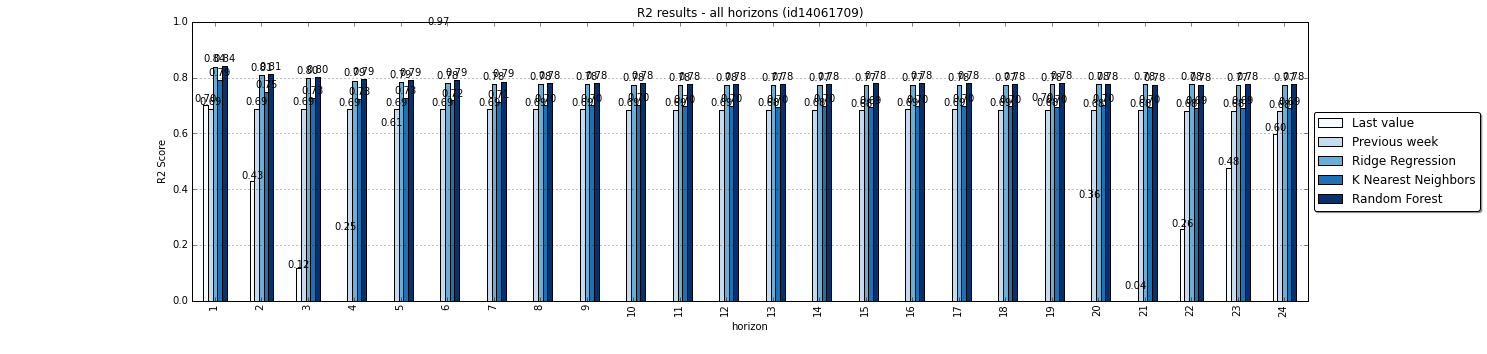

In [16]:
ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061709']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061709']['R2']).plot(
    kind='bar', figsize=(20,5), title='R2 results - all horizons (id14061709)', ylim=(0,1), colormap='Blues')

for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')

ax.yaxis.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.), ncol=5, fancybox=True, shadow=True)
#plt.legend(loc=4)
plt.ylabel('R2 Score')

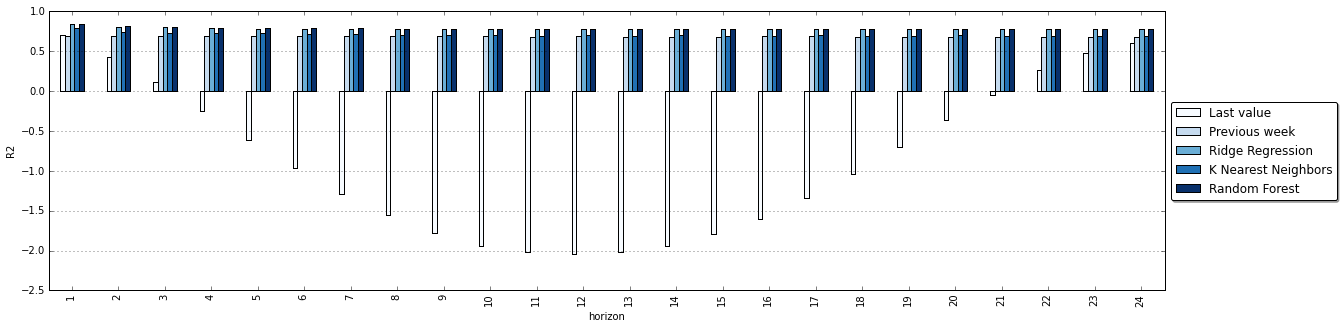

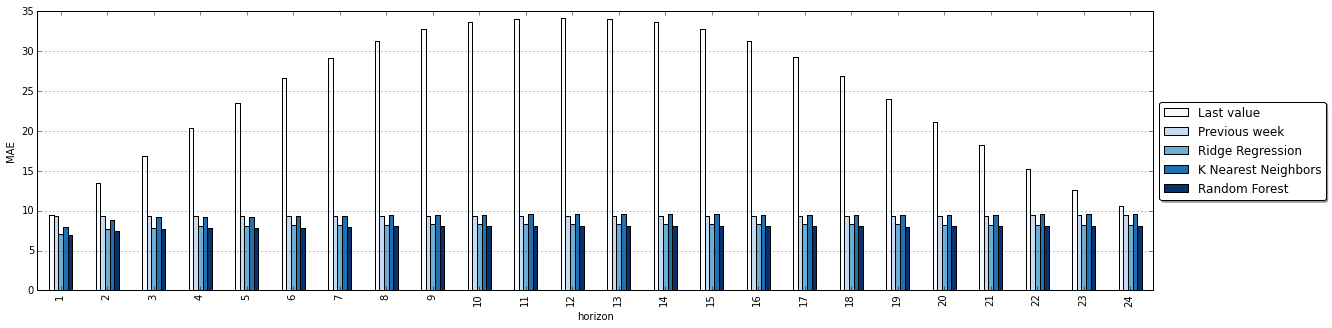

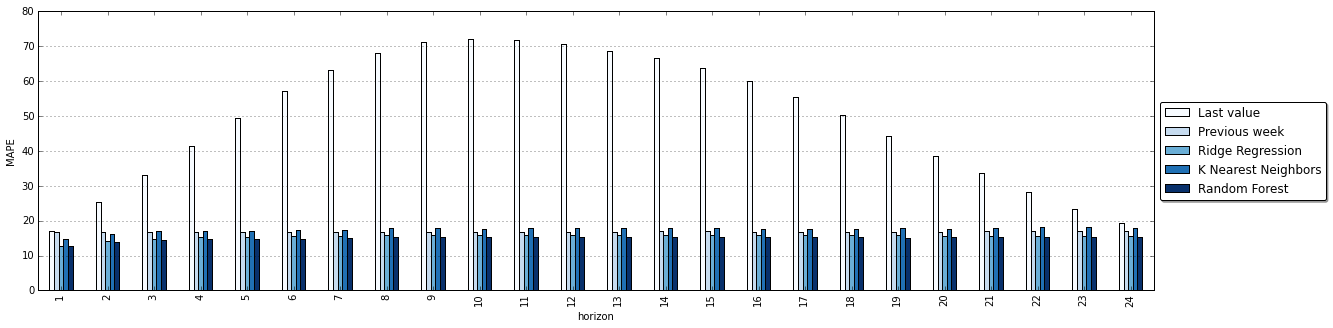

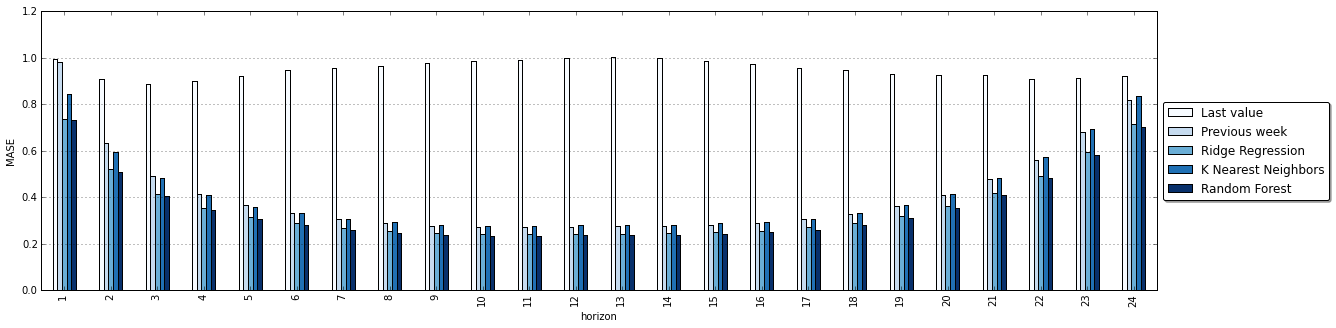

In [17]:
for measure in validation_df.columns.levels[1]:
    
    ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061709'][measure][['Last value', 'Previous week']].join(
        validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061709'][measure]).plot(
        kind='bar', figsize=(20,5), colormap='Blues')
    
    ax.yaxis.grid()   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
    plt.ylabel(measure)
 

## Average Score by Sensors and Horizons

In [16]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

error metric                                   R2       MAE       MAPE  \
dataset             model                                                
Last value          Baselines            0.561509  1.675817  29.038490   
Previous day        Baselines            0.399188  2.035682  41.442958   
Previous week       Baselines            0.655598  1.569669  30.650789   
Measurement average Baselines            0.176525  3.042106  72.821162   
AR                  Ridge Regression     0.812825  1.276349  27.640770   
                    K Nearest Neighbors  0.785566  1.356553  29.801900   
                    Random Forest        0.823768  1.255085  29.553442   
SELECTED            Ridge Regression     0.755056  1.611357  39.967885   
                    K Nearest Neighbors  0.781093  1.401275  30.995457   
                    Random Forest        0.842835  1.194789  26.340880   

error metric                                 MASE  
dataset             model                          
Last value          Baselines            0.728761  
Previous day        Baselines            0.939339  
Previous week       Baselines            0.724327  
Measurement average Baselines            1.378100  
AR                  Ridge Regression     0.575318  
                    K Nearest Neighbors  0.616033  
                    Random Forest        0.565061  
SELECTED            Ridge Regression     0.711889  
                    K Nearest Neighbors  0.631593  
                    Random Forest        0.538496

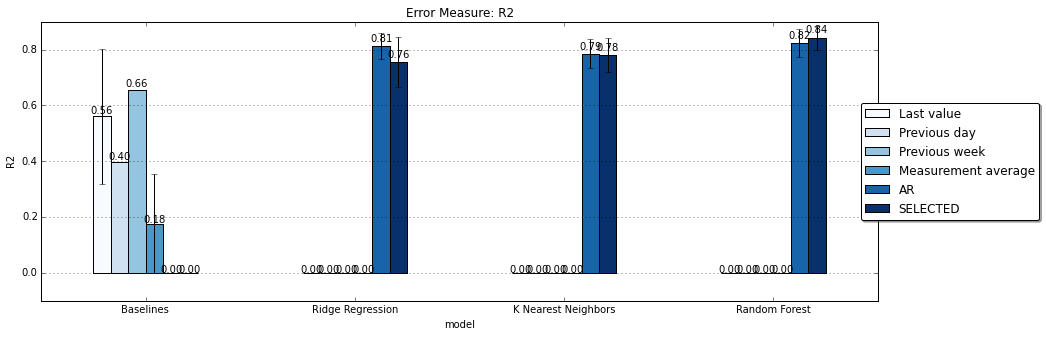

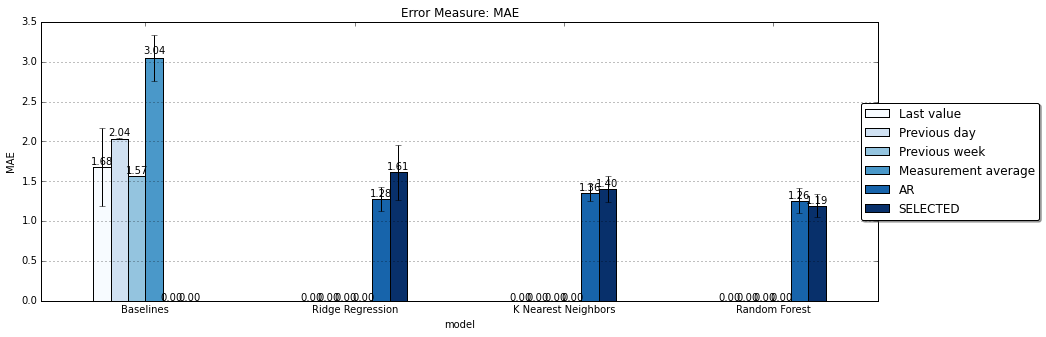

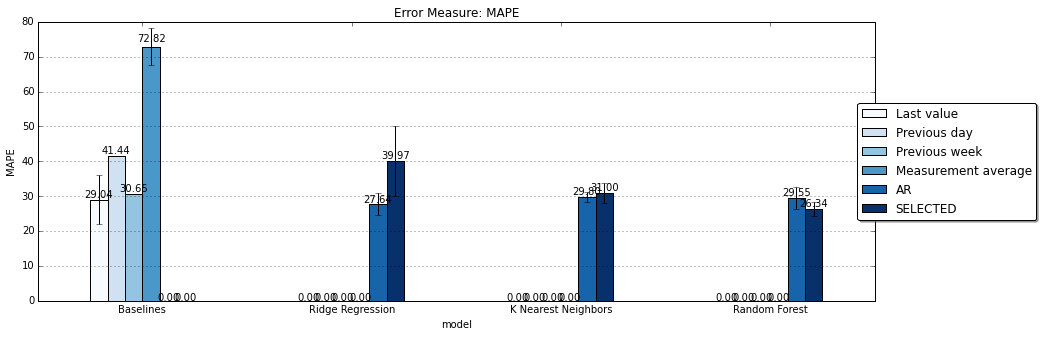

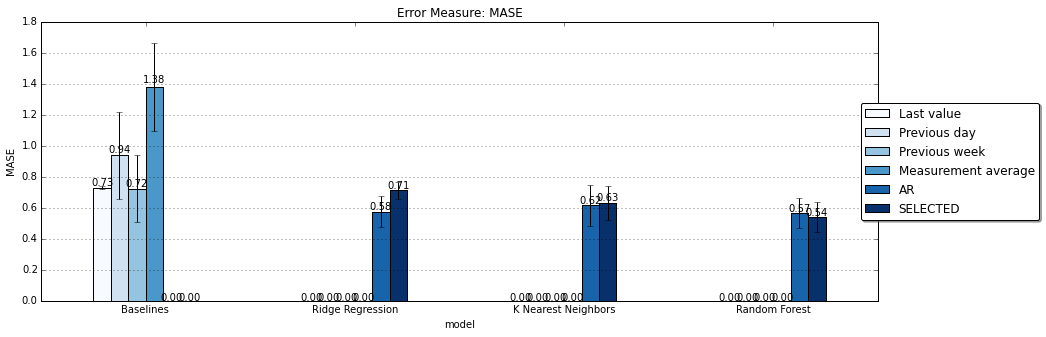

In [18]:
for measure in validation_df.columns.levels[1]:

    err = ax = validation_df.groupby(level=['dataset', 'model']).std().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.